# LLM Agent Test Notebook

## 1. Test simple LLM with HF Inference via Langraph

In [1]:
import os
from typing import Annotated, List, Optional, TypedDict

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain.tools.retriever import create_retriever_tool
from langchain_community.document_loaders import ArxivLoader, WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

# from langchain_community.vectorstores import SupabaseVectorStore
from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_core.documents import Document

# from langchain_google_genai import ChatGoogleGenerativeAI
# from langchain_groq import ChatGroq
from langchain_huggingface import (
    ChatHuggingFace,
    HuggingFaceEmbeddings,
    HuggingFaceEndpoint,
)
from langchain_ollama.chat_models import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# from supabase.client import Client, create_client
from duckduckgo_search import DDGS
import trafilatura  # pip install trafilatura
from langchain_core.tools import tool
from urllib.parse import urljoin, urlparse
import requests
from bs4 import BeautifulSoup

### Defining the LLM model

In [2]:
load_dotenv()

HF_LLM_API_TOKEN = os.getenv("HF_LLM_API_TOKEN")

# llm = ChatHuggingFace(llm=HuggingFaceEndpoint(
#     repo_id="deepseek-ai/DeepSeek-V3-0324",
#     huggingfacehub_api_token=HF_LLM_API_TOKEN
# ), verbose=True)

# LLM_MODEL = "llama3.2:1b"  # Specify the LLM model to use

# llm = ChatOllama(model=LLM_MODEL, format="json", temperature=0)

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20")

### Defining the Agent State

In [3]:
class AgentState(TypedDict):
    """State for the agent."""

    # TODO: Add any additional state variables we need
    messages: Annotated[list[AnyMessage], add_messages]

### Defining basics Agent Tools

In [4]:
# basic calculator tools
from langchain_core.tools import tool
from typing import Sequence
import math

SAFE_GLOBALS = {"__builtins__": {}, "math": math}


@tool
def calculator(expr: str) -> float:
    """
    Calculate a basic arithmetic or math expression.

    Accepted syntax
    ---------------
    • Literals: integers or floats (e.g. ``2``, ``3.14``)
    • Operators: ``+``, ``-``, ``*``, ``/``, ``**``
    • Unary minus (``-5``)
    • Functions/consts from ``math`` (e.g. ``sin(0.5)``, ``pi``)
    • Parentheses for grouping

    Parameters
    ----------
    expr : str
        The expression to evaluate.

    Returns
    -------
    float
        Result of the computation.

    Raises
    ------
    ValueError
        If the expression contains unsupported syntax or names.
    """
    try:
        if "." in expr or "__" in expr:
            raise ValueError("Attribute access not allowed")
        return eval(expr, SAFE_GLOBALS)
    except (ValueError, SyntaxError, TypeError) as exc:
        raise ValueError(f"Invalid expression '{expr}': {exc}") from exc


# ────────────────────────  generic search utils  ───────────────────────

_SEPARATOR = "\n\n---\n\n"


def _format_docs(docs: Sequence, max_chars: int = 5000) -> str:
    """Uniformly format loader docs for the LLM / calling agent."""
    if not docs:
        return "No results found."
    chunks = []
    for doc in docs:
        meta = doc.metadata
        snippet = doc.page_content[:max_chars].strip()
        chunks.append(
            f'<Document source="{meta.get("source")}" page="{meta.get("page", "")}">\n'
            f"{snippet}\n</Document>"
        )
    return _SEPARATOR.join(chunks)


# ─────────────────────────  wiki_search  ──────────────────────────


@tool
def wiki_search(query: str) -> str:
    """Return up to 2 Wikipedia pages about *query*."""
    docs = WikipediaLoader(query=query, load_max_docs=2).load()
    return _format_docs(docs)


# ─────────────────────────  web_search   ──────────────────────────


@tool
def web_search(query: str, max_results: int = 3) -> str:
    """
    Return up to `max_results` DuckDuckGo search results for *query*.

    The output is formatted by `_format_docs`, so it matches the schema your
    other tools already use.
    """
    docs = []
    with DDGS() as ddgs:
        for hit in ddgs.text(query, max_results=max_results):
            docs.append(
                Document(
                    page_content=hit.get("body") or hit.get("snippet") or "",
                    metadata={"source": hit.get("href") or hit.get("url"), "page": ""},
                )
            )

    return _format_docs(docs)


# ─────────────────────────  arxiv_search ──────────────────────────


@tool
def arxiv_search(query: str) -> str:
    """Return up to 3 recent ArXiv papers about *query*."""
    docs = ArxivLoader(query=query, load_max_docs=3).load()
    return _format_docs(docs)


# ---------- 1. Search → list of links -----------------------


@tool
def list_webpage_links(url: str, same_domain_only: bool = False) -> list[str]:
    """
    Return all unique <a href="..."> links found in the HTML at `url`.

    Parameters
    ----------
    url : str
        Page to scrape.
    same_domain_only : bool, optional
        If True, keep only links on the same domain as `url`.  Default = False.

    Returns
    -------
    list[str]
        Absolute URLs, deduplicated and sorted.
    """
    try:
        html = requests.get(url, timeout=10).text
    except Exception as exc:
        return [f"ERROR: fetch failed – {exc}"]

    base = "{uri.scheme}://{uri.netloc}".format(uri=urlparse(url))
    soup = BeautifulSoup(html, "html.parser")

    links: set[str] = set()
    for tag in soup.find_all("a", href=True):
        href: str = tag["href"].strip()
        # Convert relative → absolute
        full = urljoin(base, href)
        if same_domain_only and urlparse(full).netloc != urlparse(url).netloc:
            continue
        links.add(full)

    return sorted(links)


# ---------- 2. Browse → cleaned article text ----------------
@tool
def browse_webpage_link(url: str) -> str:
    """
    Download `url` and return the main readable text (no html, ads, nav bars).
    Relies on trafilatura’s article extractor.
    """
    raw = trafilatura.fetch_url(url)
    if raw is None:
        return "🛑 Could not fetch the page."

    text = trafilatura.extract(
        raw,
        include_comments=False,
        include_tables=False,
        include_links=False,
    )
    return text or "🛑 Page fetched but no readable text found."


@tool
def search_links_for_match(
    url: str,
    keyword: str,
    max_links: int = 100,
    same_domain_only: bool = True,
    case_sensitive: bool = False,
) -> list[str]:
    """
    Search the content of up to `max_links` found on a webpage, and return URLs that contain the given keyword.

    Parameters:
    ----------
    url : str
        The starting webpage to extract links from.
    keyword : str
        The keyword or phrase to match inside linked pages.
    max_links : int, optional
        Number of links to follow (default: 10).
    same_domain_only : bool, optional
        Only consider links from the same domain (default: True).
    case_sensitive : bool, optional
        Whether the keyword match should be case-sensitive.

    Returns:
    -------
    list[str]
        List of URLs whose content contains the keyword.
    """

    # Use the tool's .func() to access base function
    all_links = list_webpage_links.func(url=url, same_domain_only=same_domain_only)
    matched_links = []

    # Normalize keyword
    kw = keyword if case_sensitive else keyword.lower()

    for link in all_links[:max_links]:
        try:
            text = browse_webpage_link.func(link)
            if not case_sensitive:
                text = text.lower()
            if kw in text:
                matched_links.append(link)
        except Exception:
            continue

    return matched_links or ["No matches found."]

In [5]:
# # test web search
# web_search = web_search.invoke(
#     {"query": "What is the capital of France?"}
# )
# print(web_search)

In [6]:
# links = list_webpage_links.invoke(
#     {"url": "https://en.wikipedia.org/wiki/Artificial_intelligence",
#      "same_domain_only": True}
# )
# print(len(links), "links")
# print(links[:100])

In [7]:
# browse_link = browse_webpage_link.invoke(
#     {"url": "https://en.wikipedia.org/wiki/Artificial_intelligence"}
# )
# print("Browse link result:", browse_link[:200], "...")

In [8]:
# matched_links = search_links_for_match.invoke({
#     "url": "https://en.wikipedia.org/wiki/Artificial_intelligence",
#     "keyword": "machine learning",        # ← space not underscore
#     "max_links": 30,                      # scan first 30 links
#     "same_domain_only": True,
#     "case_sensitive": False
# })
# print("Matched links:", matched_links)

In [9]:
tools = [
    calculator,
    web_search,
    wiki_search,
    arxiv_search,
    list_webpage_links,
    browse_webpage_link,
    search_links_for_match,
]
# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

In [10]:
print([tool.name for tool in tools])

['calculator', 'web_search', 'wiki_search', 'arxiv_search', 'list_webpage_links', 'browse_webpage_link', 'search_links_for_match']


In [ ]:
SYSTEM_PROMPT = f"""
You are a helpful assistant tasked with answering questions using a set of tools.
You have access to the following tools:
{", ".join([tool.name for tool in tools])}
You can use these tools to search for information, perform calculations, and retrieve data from various sources.
If the tool is not available, you can try to find the information online. You can also use your own knowledge to answer the question. 
You need to provide a step-by-step explanation of how you arrived at the answer.

==========================
Here is a few examples from humans, showing you how to answer the question step by step.

Question 1: In terms of geographical distance between capital cities, which 2 countries are the furthest from each other within the ASEAN bloc according to wikipedia? Answer using a comma separated list, ordering the countries by alphabetical order.
Steps:
1. Search the web for "ASEAN bloc".
2. Click the Wikipedia result for the ASEAN Free Trade Area.
3. Scroll down to find the list of member states.
4. Click into the Wikipedia pages for each member state, and note its capital.
5. Search the web for the distance between the first two capitals. The results give travel distance, not geographic distance, which might affect the answer.
6. Thinking it might be faster to judge the distance by looking at a map, search the web for "ASEAN bloc" and click into the images tab.
7. View a map of the member countries. Since they're clustered together in an arrangement that's not very linear, it's difficult to judge distances by eye.
8. Return to the Wikipedia page for each country. Click the GPS coordinates for each capital to get the coordinates in decimal notation.
9. Place all these coordinates into a spreadsheet.
10. Write formulas to calculate the distance between each capital.
11. Write formula to get the largest distance value in the spreadsheet.
12. Note which two capitals that value corresponds to: Jakarta and Naypyidaw.
13. Return to the Wikipedia pages to see which countries those respective capitals belong to: Indonesia, Myanmar.
Tools:
1. Search engine
2. Web browser
3. Microsoft Excel / Google Sheets
Final Answer: Indonesia, Myanmar

Your Actions, to follow the human example, should be similar to the following:
1. Use the wiki_search tool to search for the ASEAN Free Trade Area.
2. Retrieve the list of member states from the Wikipedia page, and note their capitals if they are available. If not, use the web_search tool to find the capitals.
3. Once you have the capitals lists, use the web_search tool to find the GPS coordinates of each capital city.
3. Calculate the geographical distance between each pair of capitals. You can search for a formula to calculate the distance between two GPS coordinates, then use the calculator tool to perform the calculations.
4. Identify the pair of capitals with the maximum distance.
5. Provide the final answer in a comma-separated list, ordering the countries by alphabetical order.
Final Answer: Indonesia, Myanmar
==========================
IMPORTANT: if you are not able to answer the question, even with the help of the tools, you MUST say "I don't know" instead of making up an answer!!!
Report your thoughts, and finish your answer with the following template: [ANSWER]. The [ANSWER] should be a number OR as few words as possible OR a comma separated list of numbers and/or strings. If you are asked for a number, don't use comma to write your number neither use units such as $ or percent sign unless specified otherwise. If you are asked for a string, don't use articles, neither abbreviations (e.g. for cities), and write the digits in plain text unless specified otherwise. If you are asked for a comma separated list, apply the above rules depending of whether the element to be put in the list is a number or a string.

Now, please answer the following question step by step.
"""

In [12]:
def assistant(state: AgentState):
    # System message
    sys_msg = SystemMessage(content=SYSTEM_PROMPT)

    return {
        "messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],
    }

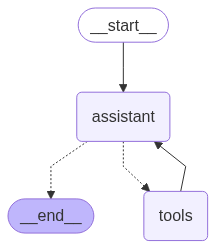

In [13]:
# The graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message requires a tool, route to tools
    # Otherwise, provide a direct response
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show the butler's thought process
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [14]:
# messages = [HumanMessage(content="Divide 6790 by 5")]
# messages = react_graph.invoke({"messages": messages})

# # Show the messages
# for m in messages['messages']:
#     m.pretty_print()

In [15]:
messages = [
    HumanMessage(
        content="What writer is quoted by Merriam-Webster for the Word of the Day from June 27, 2022?"
    )
]
messages = react_graph.invoke({"messages": messages}, config={"debug": True})

# Show the messages
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What writer is quoted by Merriam-Webster for the Word of the Day from June 27, 2022?
================================== Ai Message ==================================
Tool Calls:
  web_search (97ba28af-fcb3-444a-b964-866d03df628a)
 Call ID: 97ba28af-fcb3-444a-b964-866d03df628a
  Args:
    query: Merriam-Webster Word of the Day June 27 2022
================================= Tool Message =================================
Name: web_search

<Document source="https://www.merriam-webster.com/word-of-the-day/candidate-2022-06-27" page="">
June 27, 2022 | extreme patriotism or nationalism Jingoism originated during the Russo-Turkish War of 1877-1878, when many British citizens were hostile toward Russia and felt Britain should intervene
</Document>

---

<Document source="https://www.merriam-webster.com/word-of-the-day/calendar" page="">
Learn a new word every day! Follow Merriam-Webster for the most trusted Word 

## 2. Structured Output LLM Agent

In [8]:
from __future__ import annotations

import os
from typing import List

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_core.messages import AnyMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain.output_parsers import OutputFixingParser  # optional but handy

# ─────────────────────── 1. LLM backend ─────────────────────────── #
load_dotenv()
llm = ChatHuggingFace(
    llm=HuggingFaceEndpoint(
        repo_id="deepseek-ai/DeepSeek-V3-0324",
        huggingfacehub_api_token=os.getenv("HF_LLM_API_TOKEN"),
    ),
    verbose=False,
)

# ─────────────────────── 2. Pydantic schema ─────────────────────── #


class Answer(BaseModel):
    """Structured reply returned to the caller."""

    final_answer: str = Field(..., description="The concise answer for the user")
    reasoning: List[str] = Field(..., description="Chronological chain-of-thought")


# ───────────── 3. Parser (+ auto-repair wrapper, optional) ────────── #
# :contentReference[oaicite:0]{index=0}
base_parser = JsonOutputParser(pydantic_object=Answer)
parser = OutputFixingParser.from_llm(llm=llm, parser=base_parser, max_retries=2)
# :contentReference[oaicite:1]{index=1}
fmt_instructions = parser.get_format_instructions()

# ─────────────────────── 4. Prompt template ──────────────────────── #

SYSTEM_PROMPT = f"""
You are a helpful assistant that answers questions using a set of tools.

• Tools available: {", ".join(t.name for t in tools)}
• Use a tool whenever the information or computation is not already in your head.
• After thinking, respond with EITHER:
  • a single JSON *tool-call* (if you still need external info), OR
  • the **final JSON answer** described below.
  • Do NOT wrap the JSON in triple back-ticks.
• If you cannot answer even with tools, set "final_answer" to "I don't know".

Worked example
--------------
Q: Which ASEAN capitals are farthest apart?
→ Tool calls (look up capitals, compute distances)  
→ Final JSON:
{{
  "final_answer": "Indonesia, Myanmar",
  "reasoning": [
    "Gather capitals from Wikipedia",
    "Compute pairwise distances",
    "Select maximum distance pair"
  ]
}}
"""


PROMPT_TMPL = """{system_prompt}

{format_instructions}

Conversation so far:
{history}

User: {question}

Assistant:"""


prompt = PromptTemplate(
    template=PROMPT_TMPL,
    input_variables=["history", "question"],
    partial_variables={
        "system_prompt": SYSTEM_PROMPT,
        "format_instructions": fmt_instructions,
    },
)

# ─────────────────────── 5. Agent state ──────────────────────────── #


# ---------------- State -----------------
class AgentState(BaseModel):
    messages: List[AnyMessage] = Field(
        default_factory=list, json_schema_extra={"x_add": add_messages}
    )
    reasoning: List[str] = Field(default_factory=list)  # NEW
    final_answer: str | None = None  # NEW
    # NEW


# ─────────────────────── 6. Assistant node ───────────────────────── #


def assistant_node(state: AgentState):
    history = "\n".join(
        m.content for m in state.messages if isinstance(m, HumanMessage)
    )
    question = state.messages[-1].content
    full_prompt = prompt.format(
        system=SYSTEM_PROMPT, history=history, question=question
    )

    raw = llm.invoke(full_prompt)
    parsed = parser.parse(raw.content)

    # If you aren’t sure which type you get, normalise:
    if isinstance(parsed, dict):
        structured = Answer.model_validate(parsed)
    else:  # it’s already an Answer
        structured = parsed

    return {
        "messages": [raw],
        "final_answer": structured.final_answer,
        "reasoning": structured.reasoning,
    }


# ─────────────────────── 7. Summariser node ─────────────────────── #


def summariser(state: AgentState) -> Answer:
    return Answer(final_answer=state.final_answer, reasoning=state.reasoning)


# ─────────────────────── 8. Build LangGraph ─────────────────────── #
g = StateGraph(AgentState)
g.add_node("assistant", assistant_node)
g.add_node("tools", ToolNode(tools))  # <-- your tools list goes here
g.add_node("summarise", summariser)

g.add_edge(START, "assistant")
g.add_conditional_edges("assistant", tools_condition, ("tools", "summarise"))
g.add_edge("tools", "assistant")
g.set_finish_point("summarise")

agent = g.compile()

In [13]:
import base64
import cmath
import json
import math
import os
import re
import tempfile
import uuid
from pathlib import Path
from typing import Any, Dict, List, Optional, Sequence
from urllib.parse import urljoin, urlparse

import numpy as np
import pandas as pd
import pytesseract
import requests
import trafilatura
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from duckduckgo_search import DDGS
from groq import Groq
from langchain.agents import tool
from langchain_community.document_loaders import ArxivLoader, WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.documents import Document
from langchain_core.messages.ai import AIMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_groq import ChatGroq
from langchain_huggingface import (
    ChatHuggingFace,
    HuggingFaceEmbeddings,
    HuggingFaceEndpoint,
)
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from markitdown import MarkItDown
from PIL import Image, ImageDraw, ImageEnhance, ImageFilter, ImageFont

load_dotenv()
### =============== MATHEMATICAL TOOLS =============== ###

SAFE_GLOBALS = {"__builtins__": {}, "math": math}
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
# one Groq client reused for all calls
_GROQ_CLIENT = Groq(api_key=os.getenv("GROQ_API_KEY"))

TEMP_DIR = os.getenv("TEMP_DIR", "./tmp")  # Default temp directory
QUESTIONS_FILES_DIR = os.path.join(TEMP_DIR, "questions_files")
os.makedirs(QUESTIONS_FILES_DIR, exist_ok=True)


@tool
def calculator(expr: str) -> float:
    """
    Calculate a basic arithmetic or math expression.

    Accepted syntax
    ---------------
    • Literals: integers or floats (e.g. ``2``, ``3.14``)
    • Operators: ``+``, ``-``, ``*``, ``/``, ``**``
    • Unary minus (``-5``)
    • Functions/consts from ``math`` (e.g. ``sin(0.5)``, ``pi``)
    • Parentheses for grouping

    Parameters
    ----------
    expr : str
        The expression to evaluate.

    Returns
    -------
    float
        Result of the computation.

    Raises
    ------
    ValueError
        If the expression contains unsupported syntax or names.
    """
    try:
        if "." in expr or "__" in expr:
            raise ValueError("Attribute access not allowed")
        return eval(expr, SAFE_GLOBALS)
    except (ValueError, SyntaxError, TypeError) as exc:
        raise ValueError(f"Invalid expression '{expr}': {exc}") from exc


@tool
def multiply(a: float, b: float) -> float:
    """
    Multiplies two numbers.
    Args:
        a (float): the first number
        b (float): the second number
    """
    return a * b


@tool
def add(a: float, b: float) -> float:
    """
    Adds two numbers.
    Args:
        a (float): the first number
        b (float): the second number
    """
    return a + b


@tool
def subtract(a: float, b: float) -> int:
    """
    Subtracts two numbers.
    Args:
        a (float): the first number
        b (float): the second number
    """
    return a - b


@tool
def divide(a: float, b: float) -> float:
    """
    Divides two numbers.
    Args:
        a (float): the first float number
        b (float): the second float number
    """
    if b == 0:
        raise ValueError("Cannot divided by zero.")
    return a / b


@tool
def modulus(a: int, b: int) -> int:
    """
    Get the modulus of two numbers.
    Args:
        a (int): the first number
        b (int): the second number
    """
    return a % b


@tool
def power(a: float, b: float) -> float:
    """
    Get the power of two numbers.
    Args:
        a (float): the first number
        b (float): the second number
    """
    return a**b


@tool
def square_root(a: float) -> float | complex:
    """
    Get the square root of a number.
    Args:
        a (float): the number to get the square root of
    """
    if a >= 0:
        return a**0.5
    return cmath.sqrt(a)


# ────────────────────────  generic search utils  ───────────────────────
_SEPARATOR = "\n\n---\n\n"


def _format_docs(docs: Sequence, max_chars: int = 5000) -> str:
    """Uniformly format loader docs for the LLM / calling agent."""
    if not docs:
        return "No results found."
    chunks = []
    for doc in docs:
        meta = doc.metadata
        snippet = doc.page_content[:max_chars].strip()
        chunks.append(
            f'<Document source="{meta.get("source")}" page="{meta.get("page", "")}">\n'
            f"{snippet}\n</Document>"
        )
    return _SEPARATOR.join(chunks)


# ─────────────────────────  wiki_search  ──────────────────────────


@tool
def wiki_search(query: str) -> str:
    """Return up to 2 Wikipedia pages about *query*."""
    docs = WikipediaLoader(query=query, load_max_docs=2).load()
    return _format_docs(docs)


# ─────────────────────────  web_search   ──────────────────────────


# ``Document`` and ``_format_docs`` are provided by the host application.


######################################################################
# Public API                                                         #
######################################################################
@tool
def web_search(query: str, max_results: int = 3) -> str:
    # docstring
    """
    Return up to `max_results` Google search results for *query*.
    The output is formatted by `_format_docs`, so it matches the schema your
    other tools already use.
    """

    docs: List[Document] = []

    try:
        wrapper = GoogleSerperAPIWrapper(k=max_results)
        result_json = wrapper.results(query)

        # Primary path — structured organic hits
        for hit in result_json.get("organic", [])[:max_results]:
            docs.append(
                Document(
                    page_content=hit.get("snippet", ""),
                    metadata={"source": hit.get("link"), "page": ""},
                )
            )

        # Fallback — single‑string answer if no organic results
        if not docs:
            answer = wrapper.run(query)
            docs.append(
                Document(
                    page_content=answer,
                    metadata={"source": "serper", "page": ""},
                )
            )
    except Exception:
        # Total failure → return empty formatted structure
        pass

    return _format_docs(docs[:max_results])


# @tool
# def web_search(query: str, max_results: int = 3) -> str:
#     """
#     Return up to `max_results` DuckDuckGo search results for *query*.

#     The output is formatted by `_format_docs`, so it matches the schema your
#     other tools already use.
#     """
#     docs = []
#     with DDGS() as ddgs:
#         for hit in ddgs.text(query, max_results=max_results):
#             docs.append(
#                 Document(
#                     page_content=hit.get("body") or hit.get("snippet") or "",
#                     metadata={"source": hit.get(
#                         "href") or hit.get("url"), "page": ""},
#                 )
#             )

#     return _format_docs(docs)

# ─────────────────────────  arxiv_search ──────────────────────────


@tool
def arxiv_search(query: str) -> str:
    """Return up to 3 recent ArXiv papers about *query*."""
    docs = ArxivLoader(query=query, load_max_docs=3).load()
    return _format_docs(docs)


# ---------- 1. Search → list of links -----------------------


@tool
def list_webpage_links(url: str, same_domain_only: bool = False) -> list[str]:
    """
    Return all unique <a href="..."> links found in the HTML at `url`.

    Parameters
    ----------
    url : str
        Page to scrape.
    same_domain_only : bool, optional
        If True, keep only links on the same domain as `url`.  Default = False.

    Returns
    -------
    list[str]
        Absolute URLs, deduplicated and sorted.
    """
    try:
        html = requests.get(url, timeout=10).text
    except Exception as exc:
        return [f"ERROR: fetch failed – {exc}"]

    base = "{uri.scheme}://{uri.netloc}".format(uri=urlparse(url))
    soup = BeautifulSoup(html, "html.parser")

    links: set[str] = set()
    for tag in soup.find_all("a", href=True):
        href: str = tag["href"].strip()
        # Convert relative → absolute
        full = urljoin(base, href)
        if same_domain_only and urlparse(full).netloc != urlparse(url).netloc:
            continue
        links.add(full)

    return sorted(links)


# ---------- 2. Browse → cleaned article text ----------------
@tool
def extract_webpage_text(url: str) -> str:
    """
    Download `url` and return the main readable text (no html, ads, nav bars).
    Relies on trafilatura’s article extractor.
    """
    raw = trafilatura.fetch_url(url)
    if raw is None:
        return "🛑 Could not fetch the page."

    text = trafilatura.extract(
        raw,
        include_comments=False,
        include_tables=False,
        include_links=False,
    )
    return text or "🛑 Page fetched but no readable text found."


@tool
def search_links_for_match(
    url: str,
    keyword: str,
    max_links: int = 100,
    same_domain_only: bool = True,
    case_sensitive: bool = False,
) -> list[str]:
    """
    Search the content of up to `max_links` found on a webpage, and return URLs that contain the given keyword.

    Parameters:
    ----------
    url : str
        The starting webpage to extract links from.
    keyword : str
        The keyword or phrase to match inside linked pages.
    max_links : int, optional
        Number of links to follow (default: 10).
    same_domain_only : bool, optional
        Only consider links from the same domain (default: True).
    case_sensitive : bool, optional
        Whether the keyword match should be case-sensitive.

    Returns:
    -------
    list[str]
        List of URLs whose content contains the keyword.
    """

    # Use the tool's .func() to access base function
    all_links = list_webpage_links.func(url=url, same_domain_only=same_domain_only)
    matched_links = []

    # Normalize keyword
    kw = keyword if case_sensitive else keyword.lower()

    for link in all_links[:max_links]:
        try:
            text = browse_webpage_link.func(link)
            if not case_sensitive:
                text = text.lower()
            if kw in text:
                matched_links.append(link)
        except Exception:
            continue

    return matched_links or ["No matches found."]


### =============== DOCUMENT PROCESSING TOOLS =============== ###

# ─────────────────────────────────────────────────────────────────────────────
# MarkItDown initialisation
#   • Works out-of-the-box for PDFs, Word, PowerPoint, Excel, images, etc.
#   • If DOCINTEL_ENDPOINT is set, heavy lifting (scanned PDFs, OCR tables…)
#     is delegated to Azure Document Intelligence.
# ─────────────────────────────────────────────────────────────────────────────
_DOCINTEL_ENDPOINT = os.getenv("DOCINTEL_ENDPOINT")  # set in env if needed
_MD = MarkItDown(enable_plugins=False, docintel_endpoint=_DOCINTEL_ENDPOINT or None)


@tool("read_document", return_direct=True)
def read_document(file_path: str, max_pages: Optional[int] = 10) -> str:
    """
    Extract plain text from **any** local document supported by MarkItDown
    (PDF, DOCX, PPTX, XLSX, images, HTML,.py, etc.).

    Parameters
    ----------
    file_path : str
        Path to the document on disk.
    max_pages : int, optional
        Truncate output after this many pages/slides (only applies to
        paginated formats).  If omitted, return the full text.

    Returns
    -------
    str
        The extracted text, or an error string that starts with
        “[read_document error] …”.
    """
    path = Path(file_path).expanduser()
    if not path.exists():
        return f"[read_document error] file not found: {file_path}"

    try:
        result = _MD.convert(str(path))
        text = result.text_content or ""

        # For paginated formats MarkItDown uses form-feed (\f) between pages
        if max_pages and max_pages > 0:
            pages = text.split("\f")
            text = "\f".join(pages[:max_pages])

        cleaned = text.strip()
        return cleaned if cleaned else "[read_document] no text found"

    except Exception as err:
        return f"[read_document error] {err}"


@tool
def save_and_read_file(content: str, filename: Optional[str] = None) -> str:
    """
    Save content to a file and return the path.
    Args:
        content (str): the content to save to the file
        filename (str, optional): the name of the file. If not provided, a random name file will be created.
    """
    temp_dir = Path(QUESTIONS_FILES_DIR)
    if filename is None:
        temp_file = tempfile.NamedTemporaryFile(delete=False, dir=temp_dir)
        filepath = temp_file.name
    else:
        filepath = os.path.join(temp_dir, filename)

    with open(filepath, "w") as f:
        f.write(content)

    return f"File saved to {filepath}. You can read this file to process its contents."


@tool
def download_file_from_url(url: str, filename: Optional[str] = None) -> str:
    """
    Download a file from a URL and save it to a temporary location.
    Args:
        url (str): the URL of the file to download.
        filename (str, optional): the name of the file. If not provided, a random name file will be created.
    """
    try:
        # Parse URL to get filename if not provided
        if not filename:
            path = urlparse(url).path
            filename = os.path.basename(path)
            if not filename:
                filename = f"downloaded_{uuid.uuid4().hex[:8]}"

        # Create temporary file
        temp_dir = Path(QUESTIONS_FILES_DIR)
        filepath = os.path.join(temp_dir, filename)

        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()

        # Save the file
        with open(filepath, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        return f"File downloaded to {filepath}. You can read this file to process its contents."
    except Exception as e:
        return f"Error downloading file: {str(e)}"


# @tool
# def extract_text_from_image(image_path: str) -> str:
#     """
#     Extract text from an image using OCR library pytesseract (if available).
#     Args:
#         image_path (str): the path to the image file.
#     """
#     try:
#         # Open the image
#         image = Image.open(image_path)

#         # Extract text from the image
#         text = pytesseract.image_to_string(image)

#         return f"Extracted text from image:\n\n{text}"
#     except Exception as e:
#         return f"Error extracting text from image: {str(e)}"


@tool
def analyze_csv_file(file_path: str, query: str) -> str:
    """
    Analyze a CSV file using pandas and answer a question about it.
    Args:
        file_path (str): the path to the CSV file.
        query (str): Question about the data
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Run various analyses based on the query
        result = f"CSV file loaded with {len(df)} rows and {len(df.columns)} columns.\n"
        result += f"Columns: {', '.join(df.columns)}\n\n"

        # Add summary statistics
        result += "Summary statistics:\n"
        result += str(df.describe())

        return result

    except Exception as e:
        return f"Error analyzing CSV file: {str(e)}"


@tool
def analyze_excel_file(file_path: str, query: str) -> str:
    """
    Analyze an Excel file using pandas and answer a question about it.
    Args:
        file_path (str): the path to the Excel file.
        query (str): Question about the data
    """
    try:
        # Read the Excel file
        df = pd.read_excel(file_path)

        # Run various analyses based on the query
        result = (
            f"Excel file loaded with {len(df)} rows and {len(df.columns)} columns.\n"
        )
        result += f"Columns: {', '.join(df.columns)}\n\n"

        # Add summary statistics
        result += "Summary statistics:\n"
        result += str(df.describe())

        return result

    except Exception as e:
        return f"Error analyzing Excel file: {str(e)}"


# ─────────── vision tool ────────────────────────────
_VISION_PROMPT = """
You are a GAIA-benchmark vision assistant. Return **exactly three sections**:

1. Description – ≤40-word caption of the whole scene.
2. Objects – JSON array of {"name": str, "bbox": [x0,y0,x1,y1]} for each visible item.
3. Extracted text – verbatim text in the image or “[none]”.

No extra commentary.
""".strip()


def _b64(path: Path) -> str:
    with path.open("rb") as f:
        return base64.b64encode(f.read()).decode()


@tool("describe_image", return_direct=True)
def describe_image(local_path: str) -> str:
    """
    Caption a **local** image + list objects + OCR text using Groq’s
    meta-llama/llama-4-scout-17b-16e-instruct vision model.

    Steps for the agent:
      • If you only have a URL, first call `download_file_from_url`
        (that tool returns the tmp path). Then call this tool.

    Returns
    -------
    str
        Three-section GAIA-formatted answer, or an error string.
    """
    p = Path(local_path).expanduser()
    if not p.exists():
        return f"[describe_image] file not found: {local_path}"

    try:
        data_uri = f"data:image/{p.suffix.lstrip('.').lower()};base64,{_b64(p)}"
        resp = _GROQ_CLIENT.chat.completions.create(
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": _VISION_PROMPT},
                        {"type": "image_url", "image_url": {"url": data_uri}},
                    ],
                }
            ],
        )
        return resp.choices[0].message.content.strip()

    except Exception as err:
        return f"[describe_image error] {err}"


# ──────────────────────── audio tool ──────────────────────────────


@tool("transcribe_audio", return_direct=True)
def transcribe_audio(audio_path: str) -> str:
    """
    Transcribe spoken content from a local audio file using Groq Whisper-large-v3.

    Parameters
    ----------
    audio_path : str
        Path to a .wav/.mp3/.m4a/.flac file on disk.

    Returns
    -------
    str
        The plain-text transcription, or an error string if something fails.
    """
    p = Path(audio_path).expanduser()
    if not p.exists():
        return f"[transcribe_audio] file not found: {audio_path}"

    try:
        with p.open("rb") as fh:
            resp = _GROQ_CLIENT.audio.transcriptions.create(
                file=(p.name, fh.read()),
                model="whisper-large-v3",
                response_format="text",  # “text” → plain string in .text
            )
        txt = resp.text.strip() if hasattr(resp, "text") else str(resp).strip()
        return txt or "[empty transcription]"

    except Exception as err:
        return f"[transcribe_audio error] {err}"


tools = [
    calculator,
    wiki_search,
    web_search,
    arxiv_search,
    list_webpage_links,
    extract_webpage_text,
    search_links_for_match,
    save_and_read_file,
    download_file_from_url,
    # extract_text_from_image,
    analyze_csv_file,
    analyze_excel_file,
    read_document,
    # analyze_image,
    # transform_image,
    # draw_on_image,
    # generate_simple_image,
    # combine_images,
    multiply,
    add,
    subtract,
    divide,
    modulus,
    power,
    square_root,
    describe_image,
    transcribe_audio,
]


def get_tools() -> list:
    """
    Return the list of tools available for the agent.
    This can be used to dynamically load tools in the agent.
    """
    return tools

In [ ]:
describe_image.invoke({"local_path": "./tmp/questions_files/Cat_August_2010-4.jpg"})

'**Description**: A cat lounges on a white ledge.\n\n**Objects**: \n[\n  {"name": "cat", "bbox": [0.061, 0.184,0.969,0.874]}\n]\n\n**Extracted text**: [none]'

In [14]:
web_search.invoke({"query": "What is the capital of France?"})

'<Document source="https://en.wikipedia.org/wiki/Paris" page="">\nParis is the capital and largest city of France. With an estimated population of 2,048,472 residents in January 2025 in an area of more than 105 km2 (41 sq ...\n</Document>\n\n---\n\n<Document source="https://www.coe.int/en/web/interculturalcities/paris" page="">\nParis is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ...\n</Document>\n\n---\n\n<Document source="https://home.adelphi.edu/~ca19535/page%204.html" page="">\nParis is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011.\n</Document>'